In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
from transformers import AutoTokenizer
import os

MODEL_NAME = "vinai/bertweet-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

os.environ["TOKENIZERS_PARALLELISM"] = "false"
def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", max_length=40, truncation=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


tokenizer_tweet = TweetTokenizer()


def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’" or token == "`":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = tokenizer_tweet.tokenize(tweet.replace("’", "'").replace("…", "...").replace("`", "'"))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

text = "i hope my morning show doesn`t get cancelled!"
normalizeTweet(text)

"i hope my morning show does n't get cancelled !"

In [21]:

d= tokenize_function("Hello i am a cuck")
type(d)
# tokenizer.decode(d)


list

In [30]:
from src.data.data_module import TextDataModule
from src.features.preprocess import preprocess

dm = TextDataModule(preprocess_fn=normalizeTweet, vectorizer_fn=tokenize_function, tokenize_fn=None, 
                    batch_size=8, 
                    num_workers=8)

In [33]:
from transformers import AutoModel, AutoTokenizer 

# bertweet = AutoModel.from_pretrained(MODEL_NAME)
x = dm.subsets["train"]

{'text': ' that sounds great right about now. It`s ridiculously hot in my house',
 'labels': 0,
 'preproc_text': "that sounds great right about now . It 's ridiculously hot in my house",
 'input_ids': tensor([    0,    25,  1108,   200,   136,    62,    77,     4,    76,    20,
         17715,   586,    16,    23,   364,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [35]:
import torch
import torchmetrics
import pytorch_lightning as pl

from transformers import get_scheduler
from transformers import AutoModelForSequenceClassification

class BERTClassifier(pl.LightningModule):
    def __init__(self, num_training_steps):
        super().__init__()
        
        self.num_training_steps = num_training_steps
        self.batch_keys_keep = ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
        self.bert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
        
        self.accuracy = torchmetrics.Accuracy()
        
    def forward(self, x):
        return self.bert(**x)
        
    def training_step(self, batch, batch_idx):
        batch = self.filter_batch(batch)
        outputs = self(batch)
        loss = outputs.loss
        y_hat = outputs.logits
        y = batch["labels"]
        acc = self.accuracy(y_hat, y)
        self.log("train/loss", loss)
        self.log("train/acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        batch = self.filter_batch(batch)
        outputs = self(batch)
        val_loss = outputs.loss
        y_hat = outputs.logits
        acc = self.accuracy(y_hat, batch["labels"])
        self.log("val/loss", val_loss)
        self.log("val/acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        lr_scheduler = get_scheduler(
            name="linear", optimizer=optimizer, num_warmup_steps=0, 
            num_training_steps=self.num_training_steps
        )

        return [optimizer], [lr_scheduler]
                
    def filter_batch(self, batch):
        return {k: batch[k] for k in batch.keys() if k in self.batch_keys_keep}
    
num_epochs = 2
num_training_steps = num_epochs * len(dm.train_dataloader())

model = BERTClassifier(num_training_steps)
logger = pl.loggers.TensorBoardLogger("lightning_logs", name=MODEL_NAME)
trainer = pl.Trainer(accelerator="gpu",
                     logger=logger,
                     max_epochs=num_epochs,
                     enable_checkpointing=False)
trainer.fit(model=model, datamodule=dm)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [36]:
from tqdm.auto import tqdm
import torch.nn.functional as F
preds = []
actuals = []
probas = []
model.eval()
model.cuda()
for batch in tqdm(dm.val_dataloader()):
    with torch.no_grad():
        batch = model.filter_batch(batch)
        batch = {k: v.cuda() for k,v in batch.items()}
        outputs = model(batch)
        preds.append(torch.argmax(outputs.logits, dim=1))
        actuals.append(batch["labels"])
        probas.append(F.softmax(outputs.logits, dim=1))

preds = torch.cat(preds)
actuals = torch.cat(actuals)
probas = torch.cat(probas)

  0%|          | 0/619 [00:00<?, ?it/s]

0.8022644561261626


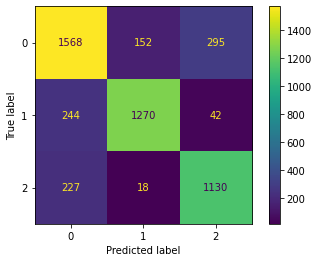

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

labels = ["neutral", "positive", "negative"]
cm = confusion_matrix(actuals.cpu().numpy(), preds.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(accuracy_score(actuals.cpu(), preds.cpu()))

In [62]:
idx = 196
probas[idx], dm.subsets["val"][idx]

(tensor([0.8163, 0.0825, 0.1012], device='cuda:0'),
 {'text': ' - Yeah I know they are **** annoying with that... But it,s such good promo... I lost some contacts for business in there',
  'labels': 1,
  'preproc_text': '- Yeah I know they are * * * annoying with that ... But it , s such good promo ... I lost some contacts for business in there',
  'input_ids': tensor([   0,   34,  799,    8,   68,   59,   41,  110,  110,  110, 1327,   30,
            25,   28,  192,   18,    7,  256,  367,   94, 6369,   28,    8,  590,
           109, 7883,   19,  763,   16,   99,    2,    1,    1,    1,    1,    1,
             1,    1,    1,    1]),
  'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])})

In [57]:
import numpy as np
np.where((preds.cpu().numpy() == 0) & (actuals.cpu().numpy() == 1) )

(array([  37,   81,  146,  175,  187,  196,  201,  228,  230,  241,  243,
         289,  324,  330,  389,  391,  399,  433,  435,  476,  479,  488,
         494,  501,  512,  543,  544,  555,  563,  581,  589,  616,  620,
         671,  681,  688,  693,  717,  718,  744,  751,  775,  884,  916,
         943,  969, 1002, 1005, 1009, 1015, 1032, 1038, 1039, 1094, 1096,
        1107, 1119, 1146, 1220, 1237, 1261, 1262, 1291, 1335, 1369, 1383,
        1393, 1397, 1400, 1413, 1430, 1444, 1469, 1498, 1525, 1535, 1591,
        1616, 1637, 1662, 1669, 1675, 1776, 1796, 1814, 1840, 1868, 1875,
        1934, 1969, 1989, 2023, 2073, 2087, 2088, 2121, 2124, 2150, 2157,
        2172, 2197, 2215, 2234, 2241, 2271, 2351, 2382, 2392, 2394, 2408,
        2434, 2442, 2455, 2469, 2478, 2481, 2518, 2520, 2541, 2564, 2585,
        2588, 2603, 2609, 2616, 2633, 2659, 2672, 2676, 2685, 2694, 2695,
        2727, 2773, 2778, 2784, 2820, 2843, 2850, 2875, 2916, 2924, 2939,
        3001, 3013, 3041, 3120, 3126, 

In [45]:
probas[true_pos_idxs, 1].cpu().numpy().squeeze()

array([0.99245185, 0.99223775, 0.99237627, ..., 0.99248815, 0.96083903,
       0.99324   ], dtype=float32)

<AxesSubplot:ylabel='Count'>

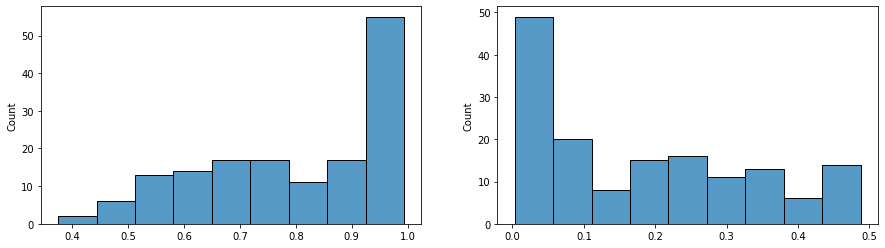

In [55]:
true_pos_idxs = np.where((preds.cpu().numpy() == 1) & (actuals.cpu().numpy() == 0))
p_pos = probas[true_pos_idxs, 1].cpu().numpy().squeeze()
p_neu = probas[true_pos_idxs, 0].cpu().numpy().squeeze()
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
sns.histplot(p_pos, ax=axs[0])
sns.histplot(p_neu, ax=axs[1])

In [ ]:
from sklearn.metrics import accuracy_score
thres = 0.7
preds_new = []
for row in probas:
    # print(row)
    if row[1] > thres:
        preds_new.append(1)
    elif row[2] > thres:
        preds_new.append(2)
    else:
        preds_new.append(0)
cm = confusion_matrix(actuals.cpu().numpy(), preds_new)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(accuracy_score(actuals.cpu(), preds_new))

In [86]:
actuals_train = []
probas_train = []
model.eval()
model.cuda()
for batch in tqdm(dm.train_dataloader()):
    with torch.no_grad():
        batch = model.filter_batch(batch)
        batch = {k: v.cuda() for k,v in batch.items()}
        outputs = model(batch)
        actuals_train.append(batch["labels"])
        probas_train.append(F.softmax(outputs.logits, dim=1))

actuals_train = torch.cat(actuals_train).cpu().numpy()
probas_train = torch.cat(probas_train).cpu().numpy()

actuals_val = []
probas_val = []
model.eval()
model.cuda()
for batch in tqdm(dm.val_dataloader()):
    with torch.no_grad():
        batch = model.filter_batch(batch)
        batch = {k: v.cuda() for k,v in batch.items()}
        outputs = model(batch)
        actuals_val.append(batch["labels"])
        probas_val.append(F.softmax(outputs.logits, dim=1))

actuals_val = torch.cat(actuals_val).cpu().numpy()
probas_val = torch.cat(probas_val).cpu().numpy()

  0%|          | 0/2474 [00:01<?, ?it/s]

In [88]:
actuals_val = actuals.cpu().numpy()
probas_val = probas.cpu().numpy()

probas_val.shape, actuals_val.shape

((4946, 3), (4946,))

In [90]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(probas_train, actuals_train)

SVC()

0.8048928427011727


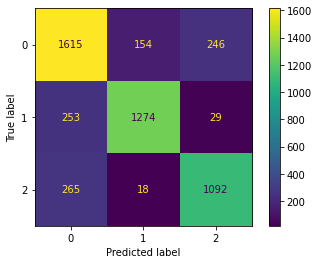

In [93]:
preds_stack = clf.predict(probas_val)
cm = confusion_matrix(actuals_val, preds_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(accuracy_score(actuals_val, preds_stack))

In [64]:
from tqdm.auto import tqdm
preds_test = []
model.cuda()
model.eval()
for batch in tqdm(dm.test_dataloader()):
    with torch.no_grad():
        batch = model.filter_batch(batch)
        batch = {k: v.cuda() for k,v in batch.items()}
        outputs = model(batch)
        preds_test.append(torch.argmax(outputs.logits, dim=1))
preds_test = torch.cat(preds_test)

  0%|          | 0/344 [00:01<?, ?it/s]

In [69]:
import pandas as pd
df_test = pd.read_csv("../data/raw/test.csv")
df_test

,textID,text,selected_text
0,102f98e5e2,Happy Mother`s Day hahaha,Happy Mother`s Day
1,033b399113,"Sorry for the triple twitter post, was having ...","Sorry for the triple twitter post, was having ..."
2,c125e29be2,thats much better than the flu syndrome!,thats much better
3,b91e2b0679,Aww I have a tummy ache,tummy ache
4,1a46141274,hey chocolate chips is good. i want a snack ...,good.
...,...,...,...
2743,0bfb1006b9,Is also having a lonely night.... Wishing she ...,Is also having a lonely night.... Wishing she ...
2744,f1df499466,o ok..im jealous..i wish I was in bed,o ok..im jealous..i wish I was in bed
2745,de4da367a4,**** your in trouble now why don`t you try w...,**** your in trouble now
2746,07a8ec4593,HAPPY MOTHER DAY FOR ALL THE STRONG HARD WORKI...,HAPPY MOTHER DAY FOR ALL THE STRONG HARD WORKI...


In [72]:
from src.utils import create_submission
create_submission(df_test, preds_test.cpu())

In [79]:
!kaggle competitions submit -c eurecom-aml-2022-challenge-3 -f submission.csv -m "BERTweet"

100%|██████████████████████████████████████| 35.7k/35.7k [00:00<00:00, 71.6kB/s]
Successfully submitted to EURECOM AML 2022:: Challenge 3

In [74]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 58 kB 9.7 MB/s eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=0305b53bb7747cb2893e8034e3c340e88a8cd164b89911168ef22f0cd266dca0
  Stored in directory: /tmp/pip-ephem-wheel-cache-wuipfj7_/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
